### Random Forest

In [210]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
from sklearn.model_selection import train_test_split # to make the test-train split of the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score # to calculate an ROC value of our model
from sklearn.metrics import confusion_matrix, precision_score, recall_score # to make confusion matrix
from sklearn.utils import shuffle

In [211]:
# read in the clean data
loans_data_clean = pd.read_csv("../data/clean_data/lending_club_loans_cleaned.csv")
# make a working copy
df = loans_data_clean.copy()

In [212]:
df.shape

(40856, 14)

In [213]:
# decided to drop 'int_rate' as it is highly-correlated with fico
# decided to drop 'sub_grade' as it will create many dummy variables, and it is equivalent to fico
df.drop(['int_rate'], axis = 1, inplace = True)
# df.drop(['fico'], axis = 1, inplace = True)
df.drop(['sub_grade'], axis = 1, inplace = True)
# df.drop(['pub_rec'], axis = 1, inplace = True)
# df.drop(['term'], axis = 1, inplace = True)
# df.drop(['addr_state'], axis = 1, inplace = True)
# df.drop(['dti'], axis = 1, inplace = True)
# df.drop(['home_ownership'], axis = 1, inplace = True)
# df.drop(['emp_length'], axis = 1, inplace = True)
# df.drop(['annual_inc'], axis = 1, inplace = True)
# df.drop(['loan_amnt'], axis = 1, inplace = True)
# df.drop(['verification_status'], axis = 1, inplace = True)
# df.drop(['issue_yr'], axis = 1, inplace = True)

In [214]:
df.shape

(40856, 12)

In [215]:
df.columns

Index(['defaulted', 'loan_amnt', 'term', 'dti', 'fico', 'pub_rec',
       'emp_length', 'home_ownership', 'verification_status', 'addr_state',
       'annual_inc', 'issue_yr'],
      dtype='object')

In [216]:
df = pd.get_dummies(df, drop_first = True)

df.head()

,defaulted,loan_amnt,dti,fico,pub_rec,annual_inc,issue_yr,term_60 months,emp_length_10+ years,emp_length_2 years,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,False,5000.0,27.65,735.0,0,24000,2011,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,True,2500.0,1.00,740.0,0,30000,2011,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,2400.0,8.72,735.0,0,12252,2011,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,False,10000.0,20.00,690.0,0,49200,2011,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,False,5000.0,11.20,730.0,0,36000,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
# split our data into the predictor and outcome variables
loans_predictors = df.drop(columns = "defaulted")
loans_response = df["defaulted"]

In [218]:
# we are interested in a prediction model, so we will create a test and train split of the data
loans_pred_train, loans_pred_test, loans_resp_train, loans_resp_test = \
train_test_split(loans_predictors, loans_response, test_size = 0.2, random_state = 7)
# the training data is 80% of our starting dataset, the test data is 20% of our starting dataset
# we use 'random_state = 7' in order to ensure the random selection gives reproducible results

In [219]:
loans_train = pd.concat([loans_pred_train, loans_resp_train], axis = 1)
defaulted = loans_train.loc[df['defaulted'] == True] 
not_defaulted = loans_train.loc[df['defaulted'] == False] 

In [220]:
resample_defaulted = resample(defaulted, replace = True, n_samples = len(not_defaulted))

In [221]:
loans_train = pd.concat([not_defaulted, resample_defaulted], axis = 0)

In [222]:
(loans_train['defaulted'].value_counts() / loans_train['defaulted'].count()) * 100

False    50.0
True     50.0
Name: defaulted, dtype: float64

In [223]:
loans_train = shuffle(loans_train)

In [224]:
loans_resp_train = loans_train.loc[:,'defaulted']
loans_pred_train = loans_train.drop(['defaulted'], axis = 1)

In [225]:
# run the model with 100 trees
model = RandomForestClassifier(n_estimators = 200)

# train the model on the training data
model.fit(loans_pred_train, loans_resp_train)

RandomForestClassifier(n_estimators=200)

In [226]:
# the model accuracy on the training data
train_score = model.score(loans_pred_train, loans_resp_train)
train_score

1.0

In [227]:
# the accuracy on the test data
test_score = model.score(loans_pred_test, loans_resp_test)
test_score

0.8348017621145375

In [228]:
# to prepare for calculation of the ROC, let's get the predicted proabilities of default from the model
pred_test = model.predict_proba(loans_pred_test)
# we have a 2d array where each row sums to 1, but we only want the second value (whether a loan defaults or not)
pred_test = pred_test[:, 1]
# now to calculate the ROC
AUC_score = roc_auc_score(y_true = loans_resp_test, y_score = pred_test)
print(AUC_score)
# the AUC score of 0.6 indicates some predictive power of the model

0.6747109343296052


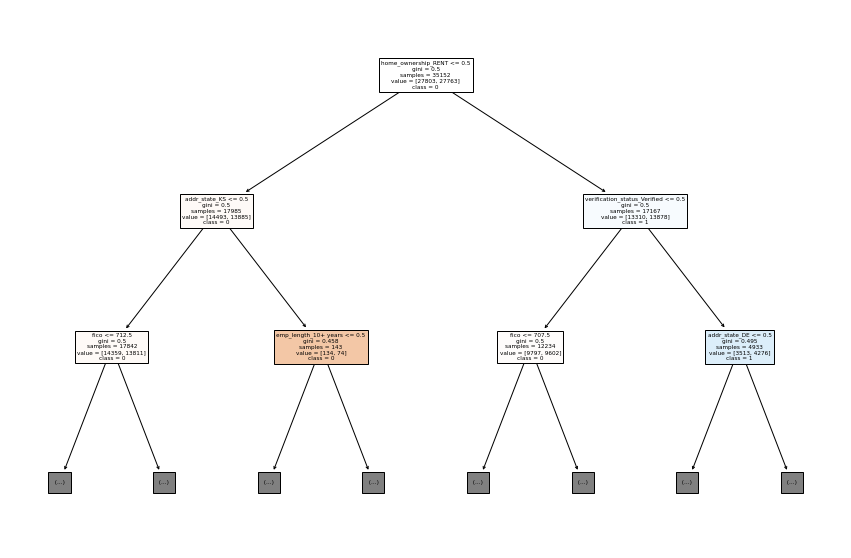

In [239]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# create a list with names of predictors, and an array with target categories for plotting
loans_pred_names = list(loans_pred_test)
loans_resp_names = ['0', '1']

# set the figure size
fig = plt.figure(figsize=(15, 10))

# plot the decision tree
plot_tree(model.estimators_[0], # Pull out one tree from the forest
          max_depth = 2, # will freeze if we try plot all of it!
          feature_names = loans_pred_names,
          class_names = loans_resp_names, 
          filled=True);

In [230]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(loans_pred_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dti                  Importance: 0.15
Variable: annual_inc           Importance: 0.15
Variable: loan_amnt            Importance: 0.13
Variable: fico                 Importance: 0.13
Variable: issue_yr             Importance: 0.04
Variable: term_60 months       Importance: 0.04
Variable: home_ownership_RENT  Importance: 0.02
Variable: verification_status_Source Verified Importance: 0.02
Variable: verification_status_Verified Importance: 0.02
Variable: addr_state_CA        Importance: 0.02
Variable: pub_rec              Importance: 0.01
Variable: emp_length_10+ years Importance: 0.01
Variable: emp_length_2 years   Importance: 0.01
Variable: emp_length_3 years   Importance: 0.01
Variable: emp_length_4 years   Importance: 0.01
Variable: emp_length_5 years   Importance: 0.01
Variable: emp_length_6 years   Importance: 0.01
Variable: emp_length_7 years   Importance: 0.01
Variable: emp_length_8 years   Importance: 0.01
Variable: emp_length_9 years   Importance: 0.01
Variable: emp_len

In [231]:
# to prepare for calculation of the ROC, let's get the predicted proabilities of default from the model
pred_test = model.predict(loans_pred_test)


cf_matrix = confusion_matrix(loans_resp_test, pred_test)
print(cf_matrix)


[[6751  155]
 [1195   71]]


<AxesSubplot:>

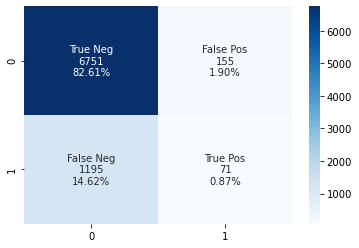

In [232]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [233]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(loans_resp_test, pred_test)

0.8348017621145375

In [234]:
# Recall
from sklearn.metrics import recall_score
recall_score = recall_score(loans_resp_test, pred_test)
print(recall_score)

0.05608214849921011


In [235]:
# Precision
from sklearn.metrics import precision_score
pred_series_test = pd.Series(pred_test)
precision_score(loans_resp_test, pred_series_test)

0.3141592920353982

In [236]:
pred_series_test.unique()

array([False,  True])

In [237]:
print(round(train_score, 2)*100, round(test_score, 2) * 100, round(AUC_score, 2) * 100, round(recall_score, 2) * 100)

100.0 83.0 67.0 6.0
